# Deep Learning for Computer Vision

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

## Session 1 : About Convolutions and CNNs ...

Welcome to this BE about applying Deep Learning for Computer Vision

We have 6 hours to do an hands on with something that looks like what you could be doing in three months time (but simplified)

We have four notebooks to go through during those 6 hours :

- One general for to get a better grasp about CNNs (it should be very quick)
- One where we will train a small aircraft classifier on a "simple" dataset and plot performance curves
- One where we will train an aircraft classifier on a more realistic dataset and plot performance curves
- The last one we will take our previously trained model and use it for real ;)

It is recommended to use Google Colab to run these notebooks

## Images

A digital image is an image composed of picture elements, also known as pixels, each with finite, discrete quantities of numeric representation for its intensity or gray level that is an output from its two-dimensional functions fed as input by its spatial coordinates denoted with x, y on the x-axis and y-axis, respectively.

We represent images as matrixes,

Images are made of pixels, and pixels are made of combinations of primary colors (in our case Red, Green and Blue). In this context, images have chanels that are the grayscale image of the same size as a color image, made of just one of these primary colors. For instance, an image from a standard digital camera will have a red, green and blue channel. A grayscale image has just one channel.

In remote sensing, channels are often referred to as raster bands.

<img src="https://miro.medium.com/max/1400/1*icINeO4H7UKe3NlU1fXqlA.jpeg" alt="drawing" width="400"/>

For the rest of this workshop we will use the following axis conventions for images

![conventions](https://storage.googleapis.com/fchouteau-isae-deep-learning/static/image_coordinates.png)

The reference library in python for working with images is https://scikit-image.org/

We will just do basic image manipulation, but you [can look at all the examples](https://scikit-image.org/docs/stable/auto_examples/) if you need to get a better grasp of image processing

In [76]:
import numpy as np
import skimage
import skimage.data
from matplotlib import pyplot as plt

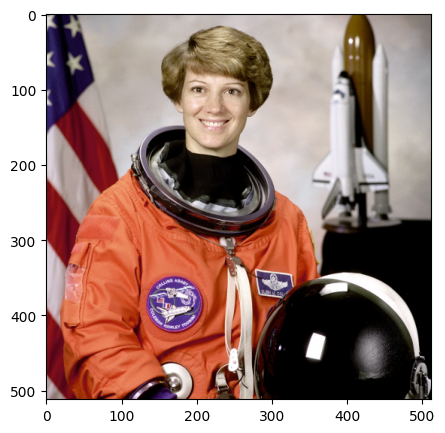

In [77]:
# Load a standard test image (astronaut) to explore image properties and pixel manipulation
img = skimage.data.astronaut()

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()

In [78]:
# What is the height, width and number of channels of this image ?
# In which order is the data represented ? Which dimensions are channels in ?
# What is the image "dtype" ?

In [79]:
# Extract the center 128 x 128 pixels on all three bands and plot it

In classical image representation, we use the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model) where the image is represented by three R,G,B channels (in that order).

Usually we also use 8bits color depth

In [80]:
# Plot the difference between the green and the red band
# don't forget to convert the image type as the image are in unsigned type

## Convolutions

You've seen this image in the previous class :

<img src="https://raw.githubusercontent.com/SupaeroDataScience/deep-learning/refs/heads/main/vision/FjvuN.gif" alt="drawing" width="400"/>

This is a convolution operator.

Someone may have told you that CNNs were the "thing" that made deep learning for image processing possible. But what are convolutions ?

First, remember that you [learnt about convolutions a long time ago 😱](https://fr.wikipedia.org/wiki/Produit_de_convolution)

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_of_spiky_function_with_box2.gif" alt="drawing" width="400"/>

So basically, we slide a filter over the signal. In 2D, this means

<img src="https://miro.medium.com/max/535/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" alt="drawing" width="400"/>

One thing you can notice is that if we slide a filter over an image we "lose" pixels at the border. This is actually quite easy to compute : assuming a of size `2*k +1` we loose `k` pixels on each side of the image.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

If you want to get them back you have to "pad" (add values at the border, for examples zeroes) the image

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/arbitrary_padding_no_strides.gif)

For more information, this website is excellent : https://cs231n.github.io/convolutional-networks/#conv

Let's play with convolutions a little bit before actually doing CNNs.

### 2D Convolution without "depth"

First, let's look at basic filtering over grayscale (1 channel) images. We will slide a filter over H,W spatial dimensions and get the result

First, the convolution implementation without depth is quite simple :

#### Understanding the Convolution Algorithm

The function below implements a basic 2D convolution from scratch. Here's what it does:

**Key Steps:**
1. **Initialize** an output array with reduced dimensions (we lose `k//2` pixels on each side)
2. **Slide** the kernel across the image pixel by pixel
3. **Element-wise multiply** the kernel with the corresponding image patch
4. **Sum** all the multiplied values to get a single output pixel
5. **Clip** values to valid pixel range [0, 255]

**Important Notes:**
- The kernel size `k` is usually odd (e.g., 3×3, 5×5) so it has a clear center pixel
- Without padding, the output is smaller than the input by `2*p` pixels (where `p = k//2`)
- This is a "valid" convolution - we only compute where the kernel fully overlaps the image
- The nested loops make this slow (real implementations use optimized C/CUDA code)

**Practical Tip:** In production, always use library implementations (OpenCV, scipy, PyTorch) which are 100-1000x faster!

In [81]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    k = kernel.shape[0]
    h, w = img.shape[:2]
    p = int(k // 2)

    # 2D array of zeros
    kernel = kernel.astype(np.float32)
    img = img.astype(np.float32)
    convolved_img = np.zeros(shape=(h - 2 * p, w - 2 * p)).astype(np.float32)

    # Iterate over the rows
    for i in range(h - 2 * p):
        # Iterate over the columns
        for j in range(w - 2 * p):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i : i + k, j : j + k]

            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))

    convolved_img = convolved_img.clip(0.0, 255.0).astype(np.uint8)

    return convolved_img

What happens if I use this filter as input ?

![identity](https://wikimedia.org/api/rest_v1/media/math/render/svg/1fbc763a0af339e3a3ff20af60a8a993c53086a7)

In [82]:
k = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
k = np.asarray(k)

k.shape
print(k)

[[0 0 0]
 [0 1 0]
 [0 0 0]]


(300, 451)


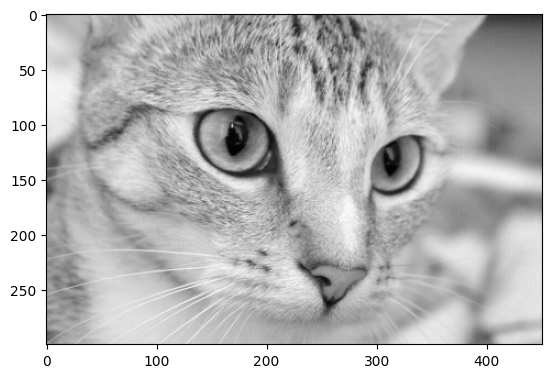

In [83]:
img = skimage.data.cat()
img = img[:, :, 0]

print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

(298, 449)


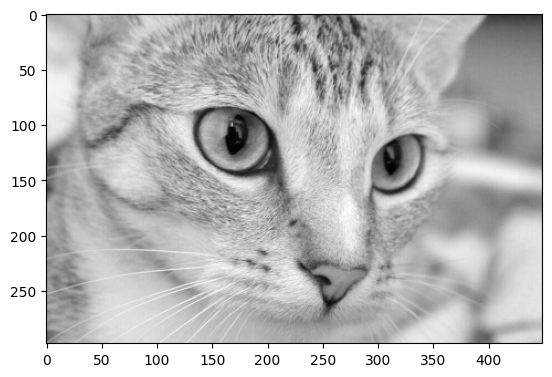

before (302, 453)
after (300, 451)


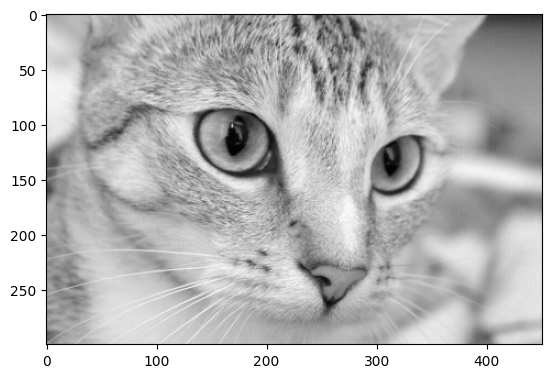

In [84]:
convolved_img = convolve(img, k)

print(convolved_img.shape)

plt.imshow(convolved_img, cmap="gray")
plt.show()

# Note the loss of 1 pixel... If we wanted to alleviate it we could do something like

img = np.pad(img, ((1, 1), (1, 1)))
print(f"before {img.shape}")
convolved_img = convolve(img, k)

print(f"after {convolved_img.shape}")

plt.imshow(convolved_img, cmap="gray")
plt.show()

#### What Just Happened? The Identity Filter Explained

The identity filter (center value = 1, all others = 0) **does nothing** - it returns the original image unchanged!

**Why is this useful?**
- It's a sanity check that our convolution implementation works correctly
- It demonstrates that the output pixel is simply a weighted sum of its neighbors
- It shows how padding helps preserve image dimensions: without padding we lost 1 pixel per side

**The Padding Trade-off:**
- **Without padding:** Output is smaller (300×300 → 298×298 for a 3×3 kernel)
- **With padding:** Output matches input size, but border pixels are less reliable (they include padded zeros)
- In practice, most deep learning frameworks offer "valid" (no padding) and "same" (with padding) options

Too easy ! Let's try another filter

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/91256bfeece3344f8602e288d445e6422c8b8a1c)

What does it do ? Take a guess

In [85]:
k = np.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).astype(np.float32)
k = k / k.sum()
print(k)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


In [86]:
# Convolve the cat image with this filter and plot it

(300, 451)


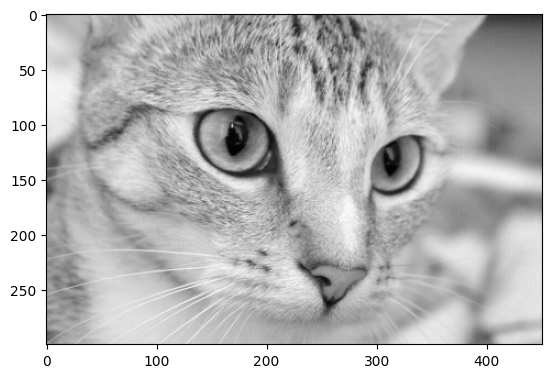

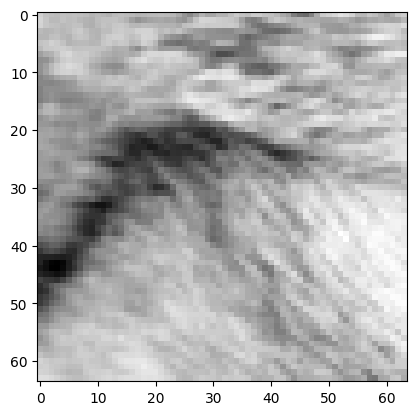

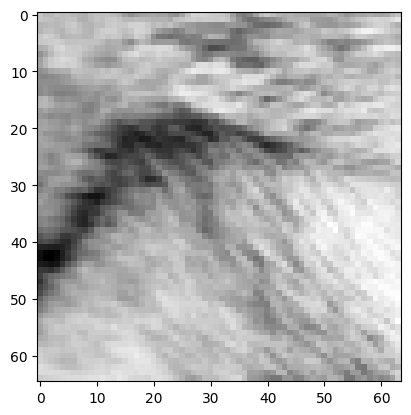

In [87]:
print(convolved_img.shape)

plt.imshow(convolved_img, cmap="gray")
plt.show()

plt.imshow(img[64:128, 64:128], cmap="gray")
plt.show()
plt.imshow(convolved_img[64:129, 64:128], cmap="gray")
plt.show()

#### The Box Blur Filter - Averaging for Smoothing

This filter contains all 1s (normalized by dividing by 9), so each output pixel is the **average of its 3×3 neighborhood**.

**Effect:** Smoothing / Blurring
- High-frequency details (edges, noise, texture) are reduced
- The image becomes "softer" - compare the zoomed regions above!
- Each pixel is replaced by the average of itself and its 8 neighbors


If we wanted, we could learn the filters in order to do... cat classification !

There are many more filters that have been designed to do interesting things, you can find an interesting list here : https://en.wikipedia.org/wiki/Kernel_(image_processing)

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2141203%2F99dba888571cd6284b9b59903061aaa4%2Fko001.png?generation=1591783791920610&alt=media)

**Takeaway message** : Kernel filtering (convolution) takes its root from classical image processing !

**Why are convolutions useful in CNNs?**
- **Not directly!** CNNs *learn* their filter values through backpropagation
- But understanding hand-crafted filters helps build intuition
- Early CNN layers often learn edge detectors (similar to Sobel filters) automatically
- Later layers learn more complex patterns built from these simple features

**Classical Computer Vision Filters:**
- **Blur:** Averaging (shown here), Gaussian blur (weighted averaging)
- **Edge Detection:** Sobel, Prewitt, Laplacian filters
- **Sharpening:** Emphasizes high-frequency content (opposite of blur)

The key insight: CNNs replace manually designed filters with learned ones!

### Convolutions with depth

Let's get back to our GIF

<img src="https://raw.githubusercontent.com/SupaeroDataScience/deep-learning/refs/heads/main/vision/FjvuN.gif" alt="drawing" width="400"/>

It's the same as above, except our filter takes all channels of the image as input. So basically a "Convolution" layer is a filter

#### Why Do We Need Convolutions with Depth?

Real images have **multiple channels** (RGB color images have 3, satellite imagery can have 10+):
- **Single-channel convolution** (what we did above) only works on grayscale images
- **Multi-channel convolution** processes all channels simultaneously:
  - The filter has depth matching the input channels (e.g., 3 for RGB)
  - We compute element-wise multiplication across ALL channels
  - Then sum everything to produce a SINGLE output pixel

**Key Insight:** A 3×3×3 filter on an RGB image:
- Has 27 values (3×3 spatial × 3 channels)
- Produces 1 output value per position
- Captures relationships between color channels (e.g., "red AND green but NOT blue" = yellow detection)

**Multiple Output Channels:** CNNs use multiple filters to detect different features:
- 64 filters → 64 output channels (feature maps)
- Each filter learns to detect a different pattern
- This is how CNNs build hierarchical representations!

**Important: Tensor Shape Conventions**

In classical image processing, we use the **(height, width, channels)** convention (e.g., 512×512×3)

However, **PyTorch and most deep learning frameworks use (channels, height, width)** (e.g., 3×512×512)

**Why the difference?**
- **Computational efficiency:** Memory layout where channels are contiguous is faster for GPU operations
- **Consistency:** Batch processing uses (batch, channels, height, width) - keeps related dimensions together
- **Convention:** Most DL papers and frameworks adopted channels-first

**Practical Impact:** You must transpose images when moving between libraries:
- `numpy/scikit-image → PyTorch`: use `.transpose((2, 0, 1))`  # (H,W,C) → (C,H,W)
- `PyTorch → matplotlib`: use `.transpose((1, 2, 0))`  # (C,H,W) → (H,W,C)

In [88]:
img = skimage.data.astronaut()
img.shape

(512, 512, 3)

In [89]:
# To transpose an image, we use
img = img.transpose((2, 0, 1))  # change channel order
img.shape

(3, 512, 512)

In [90]:
w = np.random.random((1, 3, 3, 3))
b = np.random.random((3,))

#### Understanding Multi-Channel Convolution Implementation

The function below implements a **full convolutional layer** with multiple input/output channels.

**Function Signature Breakdown:**
- `conv_W`: Filter weights with shape **(output_channels, input_channels, kernel_height, kernel_width)**
  - Example: (64, 3, 3, 3) means 64 filters, each looking at 3 input channels with 3×3 spatial size
- `conv_b`: Bias terms with shape **(output_channels,)** - one bias per output channel
- `data`: Input image with shape **(input_channels, height, width)** - channels-first format!

**Algorithm (Triple Nested Loop):**
1. **Outer loop (output_channel):** For each filter (output feature map)
2. **Middle loops (x, y):** For each spatial position in the output
3. **Implicit inner operation:** Extract patch, multiply with filter, sum ALL values

**The Math:** For each output pixel at position (x, y) in channel k:
```
output[k, x, y] = sum over all (i,j,c): data[c, x+i, y+j] * conv_W[k, c, i, j] + conv_b[k]
```
Where c iterates over input channels, and (i,j) iterates over the kernel spatial dimensions.

**Computational Cost:** For a 3×3 kernel, RGB input (3 channels), 64 output channels, 224×224 image:
- ≈ 64 × 222 × 222 × 3 × 3 × 3 ≈ 850 million multiply-add operations per image!
- This is why we need GPUs for deep learning!

In [91]:
# This is the general implementation of tensorial convolutions with channels as inputs
def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    output_channels is the number of filters in the convolution

    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """

    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros(
        (conv_channels, input_width - conv_width + 1, input_height - conv_height + 1)
    )

    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = (
                    np.sum(
                        np.multiply(
                            data[:, x : (x + conv_width), y : (y + conv_height)],
                            conv_W[output_channel, :, :, :],
                        )
                    )
                    + conv_b[output_channel]
                )

    return output

In [92]:
# Convolve the input with the weights and bias
output = forward_convolution(w, b, img)

Input (3, 512, 512)
Filter:
 [[[[0.12142485 0.34366672 0.03308938]
   [0.79865361 0.81503996 0.33960075]
   [0.23808766 0.78216587 0.05065912]]

  [[0.63429281 0.89109695 0.00619841]
   [0.69842876 0.40047133 0.35676878]
   [0.56929008 0.04601801 0.09131007]]

  [[0.11897643 0.2228391  0.80578631]
   [0.98155107 0.11353966 0.50791214]
   [0.48707908 0.20947341 0.9298531 ]]]] 
 (1, 3, 3, 3)
Bias: [0.1032203  0.68056892 0.58051135] (3,)
Input (1, 510, 510)


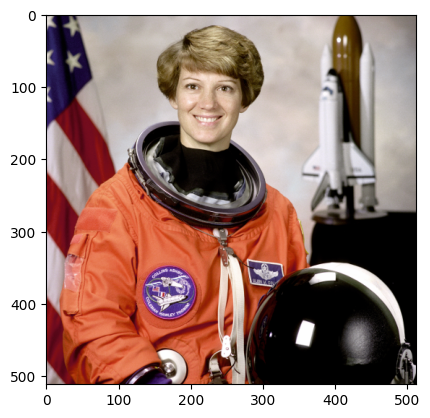

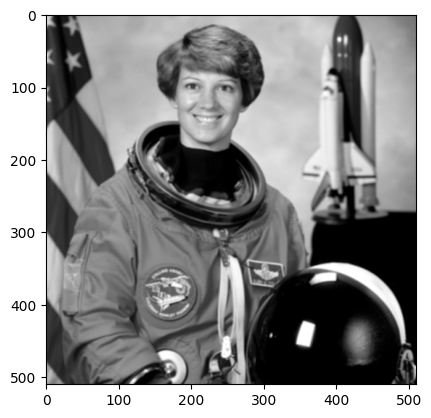

In [93]:
print("Input", img.shape)
print(f"Filter:\n {w} \n {w.shape}")
print("Bias:", b, b.shape)
print("Input", output.shape)

# Don't forget that matplotlib uses (h,w,c) to plot images !
plt.imshow(img.transpose((1, 2, 0)))
plt.show()
plt.imshow(output.transpose((1, 2, 0))[:, :, 0], cmap="gray")
plt.show()

Some useful resources for more information :

- The DL class https://github.com/fchouteau/deep-learning/blob/main/deep/Deep%20Learning.ipynb
- https://github.com/vdumoulin/conv_arithmetic
- https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

## Inductive Biases and Convolutional Neural Networks

I shamelessly copy pasted code from this excellent class : https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

Here the objective is to get a grasp of the effect of inductive biases (convolution) that respect the structure of the data.

We will go deeper into CNNs, pytorch etc. in the next notebook.

Remember, an Artificial Neural Network is a stack of

- "Fully Connected" layers
- Non linearities

A Convolutional Neural Network is a stack of
- Convolutional Layers aka Filter Banks
    - Increase dimensionality
    - Projection on overcomplete basis
    - Edge detections
- Non-linearities
    - Sparsification
    - Typically Rectified Linear Unit (ReLU): ReLU(x)=max⁡(x,0)\text{ReLU}(x) = \max(x, 0)ReLU(x)=max(x,0)
- Pooling
    - Aggregating over a feature map
    - Example : Maximum

ANN architecture

![](https://cdn-media-1.freecodecamp.org/images/Dgy6hBvOvAWofkrDM8BclOU3E3C2hqb25qBb)

Max pooling operations

<img src="https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif" alt="drawing" width="400"/>



Why do CNNs works ?

To perform well, we need to incorporate some prior knowledge about the problem

    Assumptions helps us when they are true
    They hurt us when they are not
    We want to make just the right amount of assumptions, not more than that
    
In Deep Learning

    Many layers: compositionality
    Convolutions: locality + stationarity of images
    Pooling: Invariance of object class to translations

### Definitions

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [95]:
input_size = 28 * 28  # images are 28x28 pixels
output_size = 10  # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "../data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "../data",
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=1000,
    shuffle=True,
)

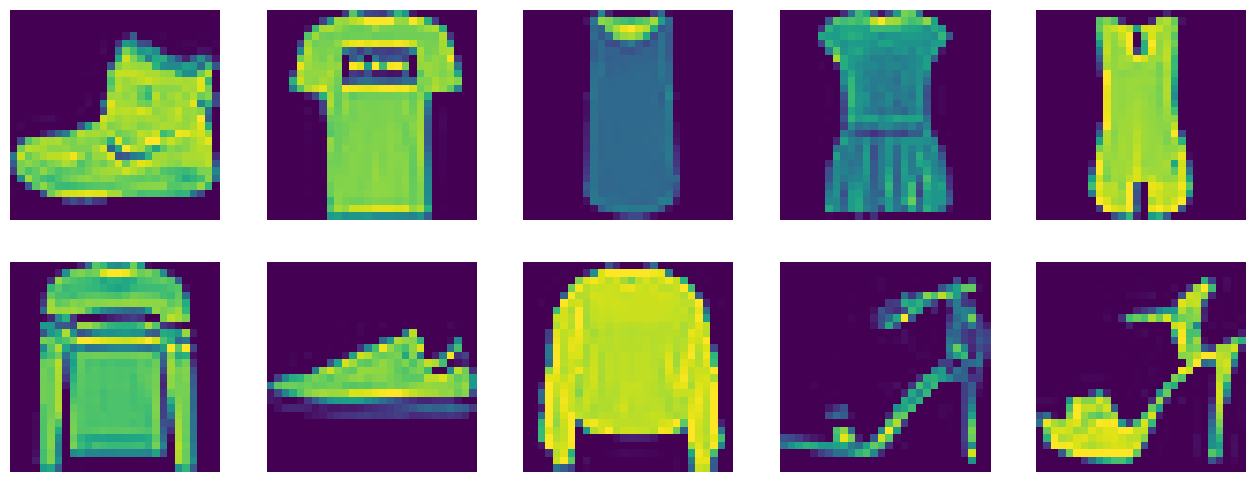

In [96]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis("off");

In [97]:
# function to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

Here is a Deep Neural network that you've seen last time

#### Fully Connected Neural Network Architecture

This is a traditional **dense neural network** where every neuron connects to every neuron in the next layer.

**Architecture:**
- **Input:** 784 values (28×28 flattened image) - spatial structure is **destroyed**!
- **Layer 1:** Linear(784 → n_hidden) + ReLU
- **Layer 2:** Linear(n_hidden → n_hidden) + ReLU
- **Layer 3:** Linear(n_hidden → 10) + LogSoftmax (for 10 classes)

**Key Characteristics:**
- **No spatial awareness:** Pixel at position (0,0) and (27,27) are treated identically
- **Ignores image structure:** Would work equally well on scrambled pixels (we'll test this!)
- **Fully general:** Makes no assumptions about the data structure

In [98]:
# Create two models: One ANN vs One CNN
class FullyConnected2Layers(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FullyConnected2Layers, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

Here is the equivalent with convolutions operations. We will go deeper on how to write and compute a CNN architecture in the next notebook, so take it for granted for now

#### Convolutional Neural Network Architecture - Layer by Layer

This CNN **preserves spatial structure** and exploits local patterns through convolutions.

**Architecture Breakdown** (for n_feature=6, input 28×28 grayscale):

1. **Conv2d(1→6, kernel=5×5)**: Applies 6 different 5×5 filters
   - Input: (1, 28, 28) → Output: (6, 24, 24) - loses 4 pixels without padding
   - Learns 6 different feature detectors (edges, corners, textures, etc.)
   - Parameters: 6 × (5×5×1 + 1 bias) = 156

2. **ReLU**: Element-wise activation: max(0, x) - introduces non-linearity

3. **MaxPool2d(2)**: Takes max in each 2×2 window, stride 2
   - Output: (6, 12, 12) - halves spatial dimensions
   - Provides translation invariance and reduces computation

4. **Conv2d(6→6, kernel=5×5)**: Second convolutional layer
   - Output: (6, 8, 8)
   - Parameters: 6 × (5×5×6 + 1)

5. **ReLU + MaxPool2d(2)**: Same as before → Output: (6, 4, 4)

6. **Flatten**: Reshapes (6, 4, 4) → (96,) - converts to 1D for fully connected layers

7. **Linear(96→50) + ReLU**: Fully connected layer combining spatial features
   - Parameters: 96×50 + 50

8. **Linear(50→10) + LogSoftmax**: Output layer for 10 classes
   - Parameters: 50×10 + 10

**Key Differences from FC Network:**
- **Sparse connectivity:** Each neuron only looks at a local region (5×5 patch)
- **Parameter sharing:** Same filter is applied across the entire image
- **Translation equivariance:** If object moves, feature map shifts accordingly
- **Hierarchical features:** Early layers detect edges, later layers detect complex patterns

In [99]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(n_feature, n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(n_feature * 4 * 4, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, verbose=False):
        return self.network(x)

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [100]:
# Apple Silicon Support
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
# NVIDIA GPU
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
# Fallback to CPU
else:
    device = torch.device("cpu")

print(device)

cpu


In [101]:
# store training history
accuracy_list = []

Here is a pytorch training loop

#### Understanding the PyTorch Training Loop

The `train()` function implements one epoch of training. Here's the standard deep learning training cycle:

**Training Loop Components:**

1. **`model.train()`**: Sets model to training mode
   - Enables dropout (if present), batch normalization updates, etc.
   - Important: Different behavior than `model.eval()`

2. **Batch Processing Loop**: Iterate over mini-batches from DataLoader
   - `enumerate(train_loader)` gives us batches of (data, target)
   - Batch size = 64 images at a time (memory efficient)

3. **Move to Device**: `data.to(device)`, `target.to(device)`
   - Transfers tensors to GPU/MPS/CPU as configured
   - Critical for GPU acceleration!

4. **The Optimization Cycle** (repeated for each batch):

   a. **`optimizer.zero_grad()`**: Clear previous gradients
      - PyTorch accumulates gradients by default - must reset!
      - Forgetting this causes incorrect updates

   b. **Forward Pass**: `output = model(data)`
      - Run input through network
      - Compute predictions

   c. **Loss Computation**: `loss = F.nll_loss(output, target)`
      - Negative log-likelihood loss for classification
      - Measures how wrong the predictions are

   d. **`loss.backward()`**: Compute gradients via backpropagation
      - Automatic differentiation! PyTorch's magic
      - Computes ∂loss/∂weight for every parameter

   e. **`optimizer.step()`**: Update weights using gradients
      - SGD update: weight = weight - learning_rate × gradient
      - With momentum: smooths updates over time

**The `perm` Parameter**: Used for pixel permutation experiment (explained later)
- Default: `torch.arange(0, 784)` keeps pixels in order
- Experiment: Random permutation to test CNN assumptions

**Practical Tips:**
- Always check loss is decreasing during training
- Print progress every N batches to monitor training
- If loss is NaN: learning rate too high or numerical instability

In [102]:
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(
            output, target, reduction="sum"
        ).item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )

#### Understanding the Test/Evaluation Function

The `test()` function evaluates model performance on unseen data without updating weights.

**Key Differences from Training:**

1. **`model.eval()`**: Sets model to evaluation mode
   - Disables dropout (use all neurons)
   - Uses running statistics for batch normalization
   - No gradient computation needed (saves memory!)

2. **No Gradient Updates**: We only need predictions, not backpropagation
   - No `optimizer.zero_grad()`, `loss.backward()`, or `optimizer.step()`
   - This makes evaluation much faster

3. **Accumulate Metrics**:
   - `test_loss`: Sum of all batch losses (then averaged)
   - `correct`: Count of correctly classified samples

4. **Loss Aggregation**: `reduction="sum"`
   - Sums loss over all samples (not average per batch)
   - Then divide by total samples for mean loss

5. **Prediction Extraction**: `output.data.max(1, keepdim=True)[1]`
   - `max(1, ...)`: Find max value along dimension 1 (class dimension)
   - `[1]`: Get indices (class labels), not values
   - Returns predicted class for each sample

6. **Accuracy Calculation**:
   - Compare predictions with ground truth: `pred.eq(target)`
   - Sum correct predictions and divide by total samples

**Best Practice:** Always evaluate on a held-out test set to detect overfitting!
- Training accuracy might be high but test accuracy low → overfitting
- Both low → underfitting (need more capacity or training)
- Both high → good generalization!

### CNNs vs Fully Connected Layers

A small FullyConnected ANN

In [103]:
n_hidden = 8  # number of hidden units

model_fnn = FullyConnected2Layers(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

print("Number of parameters: {}".format(get_n_params(model_fnn)))

# train for 5 epochs
for epoch in range(0, 2):
    train(epoch, model_fnn)
# test at end of training
test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.336790
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.844405
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.173218
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.809970
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.832300
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.693212
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.572854
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.891955
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.957121
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.793368
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.575285
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.638596
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.678403
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.575389
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.447223
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.600929
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.589478
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.510960
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.581435
Train Epoch: 1 [57600/60000 (96%)]	

A CNN with the same number of parameters

In [104]:
# Training settings
n_features = 6  # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

print("Number of parameters: {}".format(get_n_params(model_cnn)))

for epoch in range(0, 5):
    train(epoch, model_cnn)

test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308220
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.149072
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.020630
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.048185
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.802546
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.654776
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.634766
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.893522
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.569138
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.459658
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.571933
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.563883
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.513108
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.617967
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.760823
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.635243
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.682667
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.506331
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.476206
Train Epoch: 1 [57600/60000 (96%)]	

The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

    Use of convolution: Locality and stationarity in images
    Pooling: builds in some translation invariance

### What has our CNN learned ?

We will plot the filters of our CNN

Filters visualisation
0
torch.Size([6, 1, 5, 5])


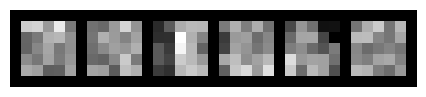

3
torch.Size([6, 6, 5, 5])


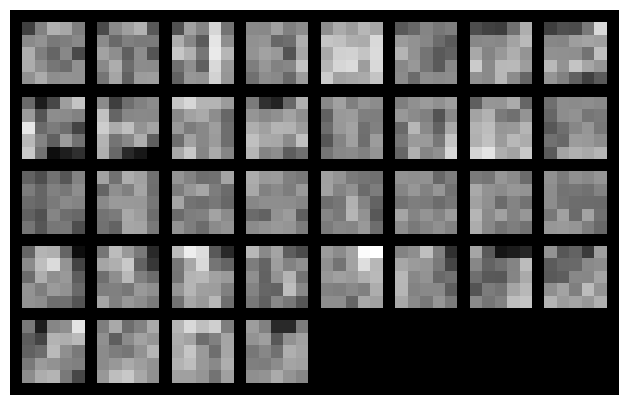

Intermediate data visualisation
torch.Size([1000, 1, 28, 28])
0 <bound method Module.type of Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))>
torch.Size([1, 6, 24, 24])


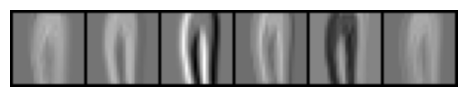

1 <bound method Module.type of ReLU()>
torch.Size([1, 6, 24, 24])


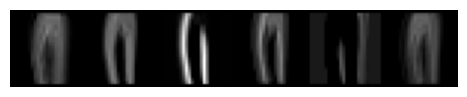

2 <bound method Module.type of MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)>
torch.Size([1, 6, 12, 12])


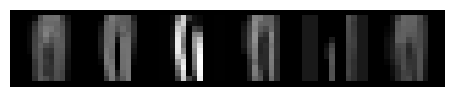

3 <bound method Module.type of Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))>
torch.Size([1, 6, 8, 8])


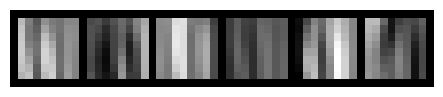

4 <bound method Module.type of ReLU()>
torch.Size([1, 6, 8, 8])


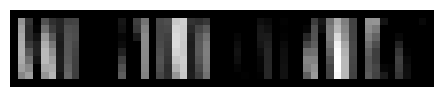

5 <bound method Module.type of MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)>
torch.Size([1, 6, 4, 4])


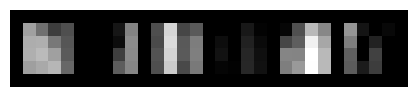

In [105]:
from torchvision import utils


def filters_visualisation(filters, ch=0, allkernels=False, nrow=8, padding=1):
    n, c, w, h = filters.shape

    if allkernels:
        filters = filters.view(n * c, -1, w, h)
    elif c != 3:
        filters = filters[:, ch, :, :].unsqueeze(dim=1)

    rows = np.min((filters.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(filters, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


print("Filters visualisation")
for k, module in enumerate(model_cnn.network):
    if isinstance(module, nn.Conv2d):
        print(k)
        filters = module.weight.clone()
        print(filters.shape)
        filters_visualisation(filters.cpu(), ch=0, allkernels=True)

        plt.axis("off")
        plt.ioff()
        plt.show()

print("Intermediate data visualisation")

for data, target in test_loader:
    inter = data[:1, :, :, :]
    print(data.shape)
    for k, module in enumerate(model_cnn.network):
        if isinstance(module, nn.Flatten):
            break
        inter = inter.to(device)
        print(k, module.type)
        inter = module(inter)
        print(inter.shape)
        filters_visualisation(inter.cpu(), ch=0, allkernels=True)
        plt.axis("off")
        plt.ioff()
        plt.show()

    break

### Why Does the CNN Win? Understanding Inductive Bias

**Inductive Bias** = assumptions built into your model architecture about the problem structure

**CNN's Inductive Biases for Images:**
1. **Locality**: Nearby pixels are more related than distant ones
   - A 5×5 convolution only looks at a small neighborhood
   - Makes sense for images: edges, corners, textures are local patterns

2. **Stationarity/Translation Equivariance**: Patterns can appear anywhere
   - Same filter used at every position (parameter sharing)
   - A "cat ear" detector works regardless of where the ear appears
   - This is why CNNs need far fewer parameters!

3. **Hierarchical Composition**: Complex patterns built from simple ones
   - Layer 1: Edges and corners
   - Layer 2: Textures and simple shapes
   - Layer 3: Object parts (eyes, wheels, wings)
   - Layer 4+: Full objects

**Fully Connected Network's Inductive Bias:**
- Essentially none! Treats all input dimensions as independent
- More flexible, but requires more data to learn the same patterns
- Can learn anything (universal approximator), but less efficient

**The Trade-off:**
- **Strong inductive bias (CNN)**: Fast learning, data-efficient, BUT suffers when assumptions break
- **Weak inductive bias (FC)**: Flexible, robust to assumption violations, BUT needs more data/parameters

Let's test this trade-off with an experiment!

### What happens when CNNs assumptions are not true ?

We will deterministically permute pixels so that the content of an image is respected but not its structure

Basically we transform some positions into others, so that the spatial relationship between pixels is not respected anymore.

We transform it the same way everytime so that it's a deterministic transformation, not a random shuffling : If we transform the same image, we will get the same results.

And we will train networks on this : A CNN (convolutional) and a ANN (fully connected)

We will then check what results the two different architectures are getting on each dataset.

In [106]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28 * 28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis("off")
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis("off")

The figure above demonstrate our "deterministic permutation" : In the 1st two rows, you see the dataset with the structured data (the numbers). In the second dataset, the content is the same but the pixels are "randomly scattered" so there are now structure.

Of course the permutation is deterministic, we always permute the pixels the same way, otherwise nothing would work!

#### Understanding the Pixel Permutation Experiment

**What we did:**
- Created a deterministic permutation: pixel position 0 → position 314, position 1 → position 621, etc.
- Applied the SAME permutation to every image consistently
- The permutation is random but fixed (not different for each image!)

**Why deterministic?**
- If we used different random permutations per image, the task becomes impossible
- With a fixed permutation, there's still a consistent mapping to learn
- The network can still learn "if pixel 314 is bright AND pixel 621 is dark, then class 3"

**What's different in the scrambled data?**
- **Content preserved**: All the same pixel values exist, just rearranged
- **Spatial structure destroyed**: Neighboring pixels in the original are now far apart
- **CNN assumptions violated**: Locality no longer valid (nearby pixels in scrambled image are unrelated)
- **FC assumptions unchanged**: FC networks don't care about pixel order anyway!

**The Hypothesis:**
- CNN should perform WORSE on scrambled data (inductive bias doesn't help)
- FC should perform the SAME on both (no spatial assumptions to break)

Let's see if this hypothesis holds!

First, let's train a CNN on the scrambled data

In [107]:
# Training settings
n_features = 6  # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_cnn)))

for epoch in range(0, 5):
    train(epoch, model_cnn, perm)

test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311280
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.221816
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.995243
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.434038
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.210874
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.841630
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.884396
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.771060
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.827628
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.554450
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.834466
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.691232
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.845304
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.692244
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.679844
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.496100
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.633124
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.760049
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.585183
Train Epoch: 1 [57600/60000 (96%)]	

Then, a fully connected neural nets on the same scrambled data

In [108]:
n_hidden = 8  # number of hidden units

model_fnn = FullyConnected2Layers(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_fnn)))

for epoch in range(0, 5):
    train(epoch, model_fnn, perm)

test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.377686
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.572345
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.202120
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.869206
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.950913
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.875053
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.775188
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.677643
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.862636
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.550143
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.835734
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.559898
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.594340
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.502663
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.416623
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.347398
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.639758
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.530125
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.487413
Train Epoch: 1 [57600/60000 (96%)]	

Let's now compare the accuracies of 4 neural networks :
- CNN with image assumption
- FC with image assumption
- CNN without image assumption
- FC with image assumption

#### Interpreting the Results: The Power and Limits of Inductive Bias

The bar chart below reveals a fundamental principle in machine learning architecture design.

**Expected Results:**

1. **CNN on Normal Data (Highest)**: ~85-90% accuracy
   - Assumptions match reality → maximum benefit from inductive bias
   - Learns efficiently with few parameters

2. **FC on Normal Data (Good)**: ~75-80% accuracy
   - No built-in assumptions, must learn spatial structure from scratch
   - Requires more data/parameters to match CNN performance

3. **FC on Scrambled Data (Same as #2)**: ~75-80% accuracy
   - **Key insight**: Performance unchanged!
   - No spatial assumptions to violate
   - Treats pixels as independent features regardless of order

4. **CNN on Scrambled Data (Worst)**: ~60-70% accuracy
   - **Critical drop**: Inductive bias now hurts!
   - Convolutions assume nearby pixels are related (they're not anymore)
   - Parameter sharing means it can't learn independent pixel relationships

**The Fundamental Trade-off:**

| Architecture | Assumptions | When Good | When Bad |
|--------------|-------------|-----------|----------|
| **CNN** | Strong spatial priors | Structured grid data (images, audio spectrograms) | Unstructured data, tabular data |
| **FC** | No assumptions | Any data type, especially when structure is unknown | Images/sequences (needs more data) |

**Practical Takeaways:**

1. **Use CNNs for images** - the inductive bias is almost always helpful
2. **Don't use CNNs for tabular data** - no spatial structure to exploit
3. **Architecture choice encodes assumptions** - choose based on data structure
4. **More assumptions ≠ always better** - assumptions must match reality
5. **Data efficiency**: Right assumptions dramatically reduce data needs

**Modern Extensions:**
- **Vision Transformers (ViT)**: Less inductive bias than CNNs, needs more data but more flexible
- **Graph Neural Networks**: Inductive bias for graph-structured data
- **Transformers**: Minimal assumptions, sequence order learned from position embeddings

This experiment beautifully demonstrates why **architecture matters** in deep learning!

**Takeaway messages**

The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

    ConvNet makes the assumption that pixels lie on a grid and are stationary/local
    It loses performance when this assumption is wrong
    The fully-connected network does not make this assumption
    It does less well when it is true, since it doesn't take advantage of this prior knowledge
    But it doesn't suffer when the assumption is wrong

In [109]:
plt.bar(
    ("NN normal", "CNN normal", "CNN scrambled", "NN scrambled"),
    accuracy_list,
    width=0.4,
)
plt.ylim((min(accuracy_list) - 5, 96))
plt.ylabel("Accuracy [%]")
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label1.set_fontsize(10)
plt.title("Performance comparison");